## 多项式回归

我们现在可以(**通过多项式拟合来探索这些概念**)。

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

# 这一步的广播机制要好好理解下
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
poly_features.shape

(200, 20)

同样，存储在`poly_features`中的单项式由gamma函数重新缩放，
其中$\Gamma(n)=(n-1)!$。

从生成的数据集中[**查看一下前2个样本**]，
第一个值是与偏置相对应的常量特征。

In [4]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [5]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.9533],
         [-0.4532]]),
 tensor([[ 1.0000e+00,  1.9533e+00,  1.9076e+00,  1.2420e+00,  6.0651e-01,
           2.3694e-01,  7.7134e-02,  2.1523e-02,  5.2551e-03,  1.1405e-03,
           2.2277e-04,  3.9558e-05,  6.4390e-06,  9.6746e-07,  1.3498e-07,
           1.7577e-08,  2.1458e-09,  2.4655e-10,  2.6754e-11,  2.7504e-12],
         [ 1.0000e+00, -4.5320e-01,  1.0270e-01, -1.5514e-02,  1.7577e-03,
          -1.5932e-04,  1.2034e-05, -7.7913e-07,  4.4138e-08, -2.2226e-09,
           1.0073e-10, -4.1500e-12,  1.5673e-13, -5.4640e-15,  1.7688e-16,
          -5.3441e-18,  1.5137e-19, -4.0354e-21,  1.0160e-22, -2.4235e-24]]),
 tensor([7.7833, 4.1173]))

### 对模型进行训练和测试

首先让我们[**实现一个函数来评估模型在给定数据集上的损失**]。

In [6]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在[**定义训练函数**]。

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### [**三阶多项式函数拟合(正常)**]

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

weight: [[ 5.0004787  1.1800133 -3.3916767  5.6184077]]


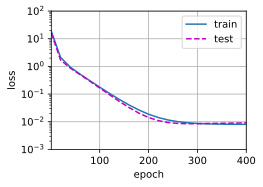

In [8]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

### [**高阶多项式函数拟合(过拟合)**]

现在，让我们尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。

weight: [[ 4.9878736   1.2378285  -3.3194604   5.2449803  -0.27013564  1.2697095
   0.13900568  0.32693112 -0.18748769  0.1449756  -0.14792427 -0.01647165
  -0.15363114 -0.05138394 -0.08820634 -0.14946103  0.02524592  0.21851507
  -0.13055326  0.07208329]]


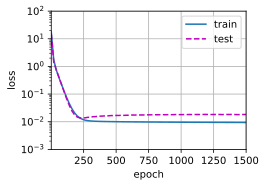

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

### [**线性函数拟合(欠拟合)**]

让我们再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

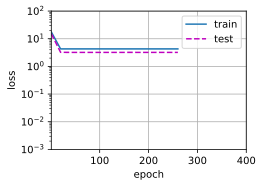

In [ ]:
# 从多项式特征中选择前2个维度，即1和x
# train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

在接下来的章节中，我们将继续讨论过拟合问题和处理这些问题的方法，例如权重衰减和dropout。

## 小结

* 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
* 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
* 验证集可以用于模型选择，但不能过于随意地使用它。
* 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。